<a href="https://colab.research.google.com/github/jdannem6/ML_Forex_Forecasting/blob/main/varima_eurgbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/jdannem6/ML_Forex_Forecasting

Cloning into 'ML_Forex_Forecasting'...
remote: Enumerating objects: 416, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 416 (delta 158), reused 222 (delta 112), pack-reused 127
Receiving objects: 100% (416/416), 42.21 MiB | 22.54 MiB/s, done.
Resolving deltas: 100% (168/168), done.


In [2]:
import sys
sys.path.append('/ML_Forex_Forecasting')
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Data Extraction #

In [3]:
eur_gbp = pd.read_csv("/content/ML_Forex_Forecasting/EURGBP=X.csv", parse_dates=['Date'])
eur_gbp = eur_gbp[['Date', 'Close', 'Open', 'High', 'Low']]
print(f"eur_gbp: {eur_gbp.shape}")
display(eur_gbp.head())

eur_gbp: (262, 5)


,Date,Close,Open,High,Low
0,2022-12-08,0.86072,0.86072,0.86446,0.86060
1,2022-12-09,0.86277,0.86277,0.86370,0.85629
2,2022-12-12,0.85900,0.85965,0.86118,0.85825
3,2022-12-13,0.85899,0.85909,0.86044,0.85595
4,2022-12-14,0.86000,0.86000,0.86147,0.85779


In [4]:
gold = pd.read_csv("/content/ML_Forex_Forecasting/GC=F.csv", parse_dates=['Date'])
gold = gold[['Date', 'Close']]
gold.rename(columns = {'Close' : 'Gold'}, inplace = True)

stoxx = pd.read_csv("/content/ML_Forex_Forecasting/STOXX50E.csv", parse_dates=['Date'])
stoxx = stoxx[['Date', 'Close']]
stoxx.rename(columns = {'Close' : 'Stoxx'}, inplace = True)

smi = pd.read_csv("/content/ML_Forex_Forecasting/FTSE.csv", parse_dates=['Date'])
smi = smi[['Date', 'Close']]
smi.rename(columns = {'Close' : 'FTSE'}, inplace = True)

print(f"Gold: {gold.shape}")
display(gold.head())
print(f"STOXX: {stoxx.shape}")
display(stoxx.head())
print(f"SMI: {smi.shape}")
display(smi.head())

Gold: (252, 2)


,Date,Gold
0,2022-12-09,1798.099976
1,2022-12-12,1780.500000
2,2022-12-13,1813.900024
3,2022-12-14,1807.500000
4,2022-12-15,1777.199951


STOXX: (254, 2)


,Date,Stoxx
0,2022-12-08,3921.270020
1,2022-12-09,3942.620117
2,2022-12-12,3921.820068
3,2022-12-13,3986.830078
4,2022-12-14,3975.260010


SMI: (253, 2)


,Date,FTSE
0,2022-12-08,7472.200195
1,2022-12-09,7476.600098
2,2022-12-12,7446.000000
3,2022-12-13,7502.899902
4,2022-12-14,7495.899902


In [5]:
df = eur_gbp.merge(gold[['Date', 'Gold']], on = 'Date', how = 'inner')
df = df.merge(stoxx[['Date', 'Stoxx']], on = 'Date', how = 'inner')
df = df.merge(smi[['Date', 'FTSE']], on = 'Date', how = 'inner')

df

,Date,Close,Open,High,Low,Gold,Stoxx,FTSE
0,2022-12-09,0.86277,0.86277,0.86370,0.85629,1798.099976,3942.620117,7476.600098
1,2022-12-12,0.85900,0.85965,0.86118,0.85825,1780.500000,3921.820068,7446.000000
2,2022-12-13,0.85899,0.85909,0.86044,0.85595,1813.900024,3986.830078,7502.899902
3,2022-12-14,0.86000,0.86000,0.86147,0.85779,1807.500000,3975.260010,7495.899902
4,2022-12-15,0.85954,0.85954,0.87219,0.85913,1777.199951,3835.699951,7426.200195
...,...,...,...,...,...,...,...,...
240,2023-12-04,0.85641,0.85641,0.85847,0.85626,2024.099976,4414.950195,7513.000000
241,2023-12-05,0.85778,0.85778,0.85861,0.85640,2018.500000,4452.770020,7489.799805
242,2023-12-06,0.85695,0.85695,0.85737,0.85537,2030.500000,4483.259766,7515.399902
243,2023-12-07,0.85717,0.85717,0.85820,0.85530,2029.900024,4473.770020,7513.700195


In [6]:
cols = df.columns[1:]

# Dickey fuller stationarity test #

In [7]:
def dickey_fuller_test(df,var, verbose = False):
    result = adfuller(df[var].values)
    #Extracting the values from the results:
    if verbose:

        print(f"Dickey-Fuller test for feature: {var}")

        print('Test Statistic: %f' % result[0])

        print('p-value: %f' % result[1])

        print('Critical Values:')

        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        if result[0] < result[4]["5%"]:
            print ("Reject H0 - Time Series is Stationary")
        else:
            print ("Failed to Reject H0 - Time Series is Non-Stationary")

    if result[0] < result[4]["5%"]:
        return True

    return False

In [8]:
def test_stationarity(df, cols):
    res = {}
    for col in cols:
        if not dickey_fuller_test(df, col, verbose = False):
            res[col] = False
        else:
            res[col] = True
    return res

In [9]:
test_stationarity(df, cols)

{'Close': False,
 'Open': False,
 'High': False,
 'Low': False,
 'Gold': True,
 'Stoxx': False,
 'FTSE': False}

In [10]:
diff_data = diff(df, k_diff = 1)
test_stationarity(diff_data, cols)

{'Close': True,
 'Open': True,
 'High': True,
 'Low': True,
 'Gold': True,
 'Stoxx': True,
 'FTSE': True}

# Granger causality #

In [11]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, maxlag = 15, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [12]:
grangers_causation_matrix(diff_data, cols)

# high, low, gold, FTSE cause close
# close causes open, high, low, gold, stoxx

# endo -> open, high, low, gold
# exo -> FTSE


,Close_x,Open_x,High_x,Low_x,Gold_x,Stoxx_x,FTSE_x
Close_y,1.0000,0.0158,0.0000,0.0000,0.0007,0.4024,0.0008
Open_y,0.0135,1.0000,0.0000,0.0000,0.0008,0.4294,0.0008
High_y,0.0143,0.0167,1.0000,0.0000,0.1950,0.0145,0.0045
Low_y,0.0065,0.0056,0.0000,1.0000,0.1757,0.1427,0.1768
Gold_y,0.0193,0.0187,0.2680,0.4917,1.0000,0.1930,0.1357
Stoxx_y,0.0184,0.0208,0.0150,0.2118,0.0254,1.0000,0.0397
FTSE_y,0.0623,0.0619,0.0461,0.2502,0.2521,0.1715,1.0000


# Autocorrelograms #

In [13]:
def plot_autocorrelograms(df,var):
    ACF = plot_acf(df[var].dropna(),lags=20)
    plt.title(f"Autocorrelation for {var}")
    PACF = plot_pacf(df[var].dropna(),lags=20)
    plt.title(f"Partial Autocorrelation for {var}")

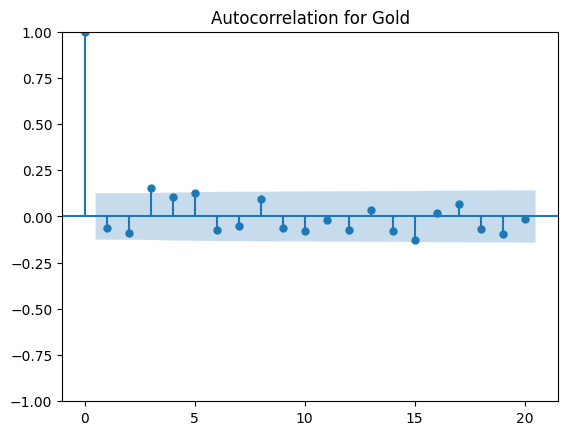

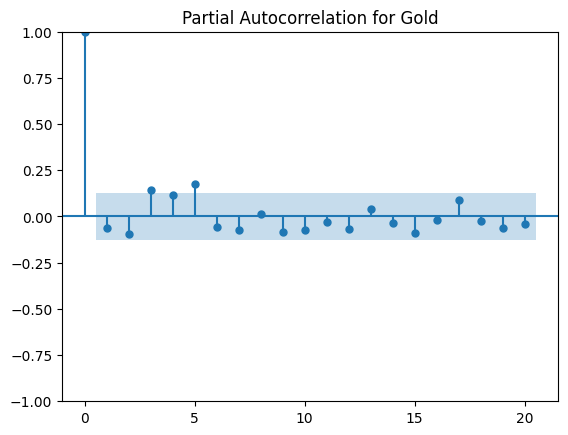

In [14]:
plot_autocorrelograms(diff_data, 'Gold')

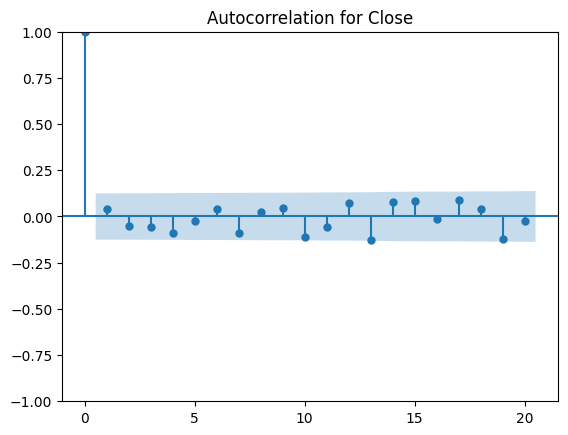

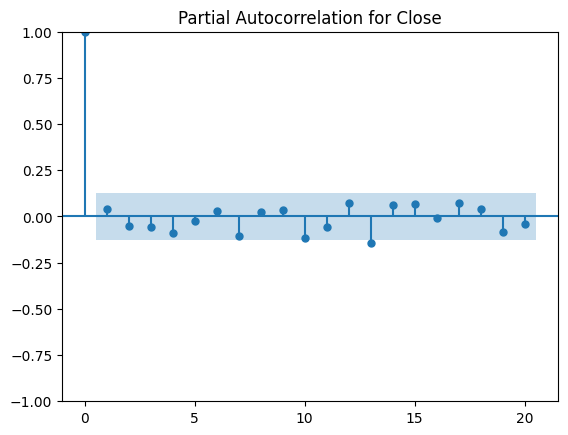

In [15]:
plot_autocorrelograms(diff_data, 'Close')

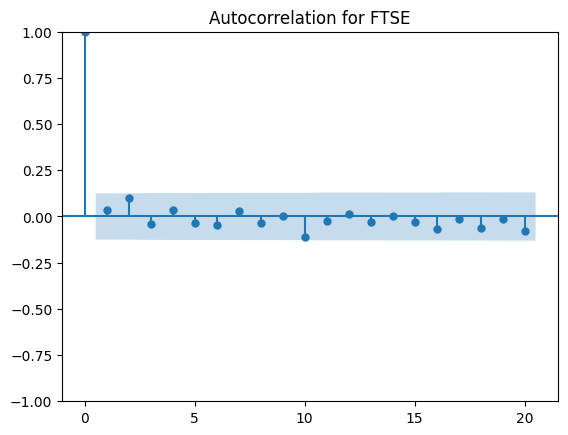

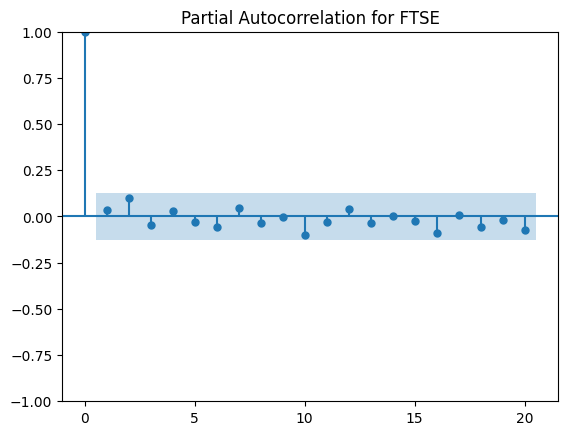

In [16]:
plot_autocorrelograms(diff_data, 'FTSE')

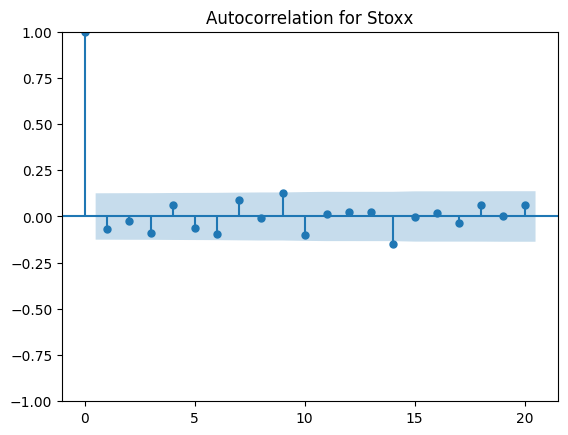

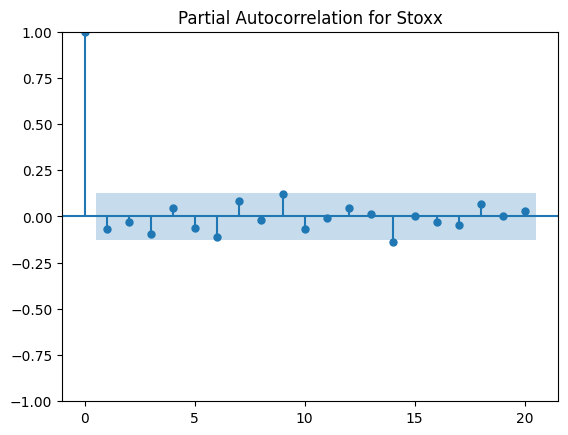

In [17]:
plot_autocorrelograms(diff_data, 'Stoxx')

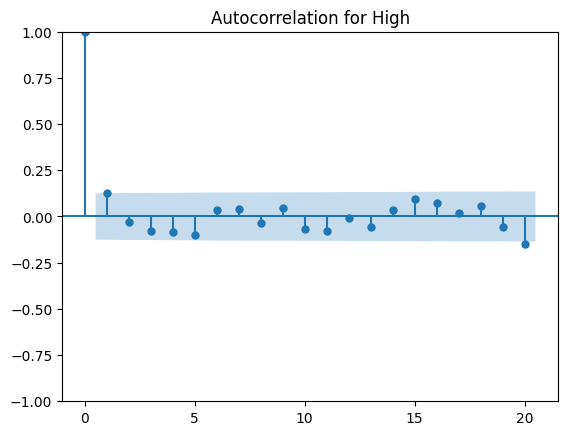

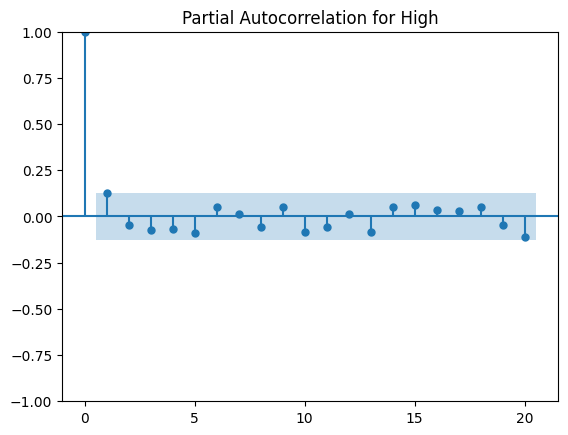

In [18]:
plot_autocorrelograms(diff_data, 'High')

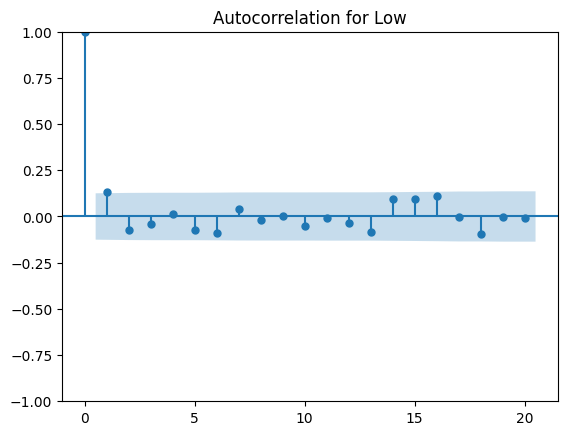

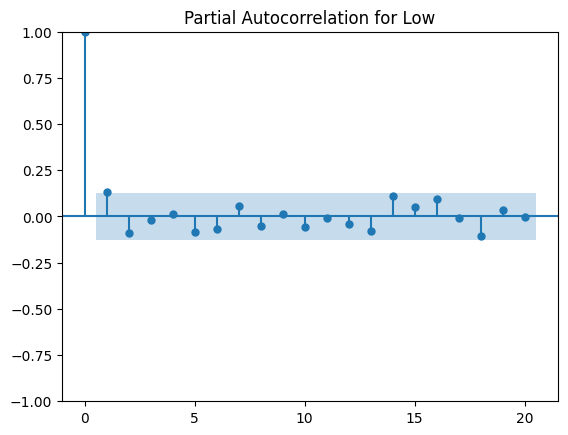

In [19]:
plot_autocorrelograms(diff_data, 'Low')

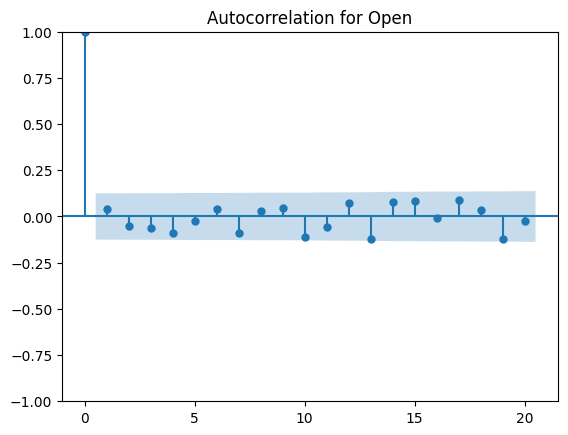

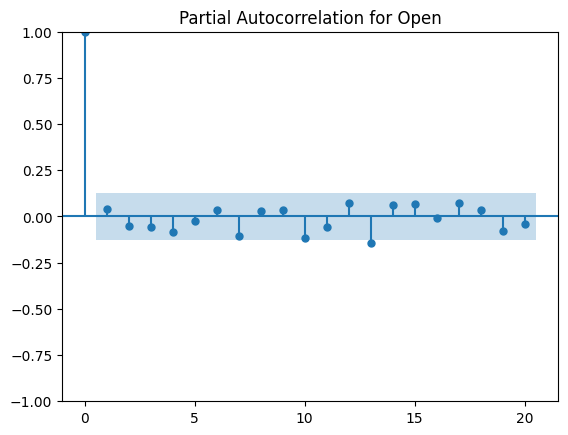

In [20]:
plot_autocorrelograms(diff_data, 'Open')

# Tests #

In [21]:
data = df.copy()
df = data.dropna()

train, test = df[:-5], df[-5:]

data = train

diff_data = diff(data, k_diff=1)
diff_test = diff(df[-6:], k_diff=1)

p = np.arange(1,6)
q = [1, 2, 4, 6]
models = []
orders = []
MSEs = []
for i in p:
    for j in q:
        orders.append((i,j))
        model = VARMAX(endog=diff_data[['Close','High', 'Low', 'Gold']], order=(i,j), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse')
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['FTSE']]).reset_index(drop=True).Close)
        pred['observed'] = test.reset_index(drop=True).Close
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax

In [22]:
idx = np.argmin(MSEs)
print(orders[idx])
model_fit = models[idx]


(1, 2)


In [23]:
diff_test

,Date,Close,Open,High,Low,Gold,Stoxx,FTSE
240,3 days,-0.00579,-0.00579,-0.00513,-0.00104,-46.900024,-3.559571,-16.399902
241,1 days,0.00137,0.00137,0.00014,0.00014,-5.599976,37.819825,-23.200195
242,1 days,-0.00083,-0.00083,-0.00124,-0.00103,12.000000,30.489746,25.600097
243,1 days,0.00022,0.00022,0.00083,-0.00007,-0.599976,-9.489746,-1.699707
244,1 days,0.00055,-0.00008,0.00062,0.00107,-31.599975,49.540039,40.770020


In [24]:
data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['FTSE']]).reset_index(drop=True).Close)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


0    0.859280
1    0.859469
2    0.859564
3    0.859547
4    0.859536
Name: Close, dtype: float64

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Text(0.5, 1.0, 'MSE = 5.373089093662016e-06')

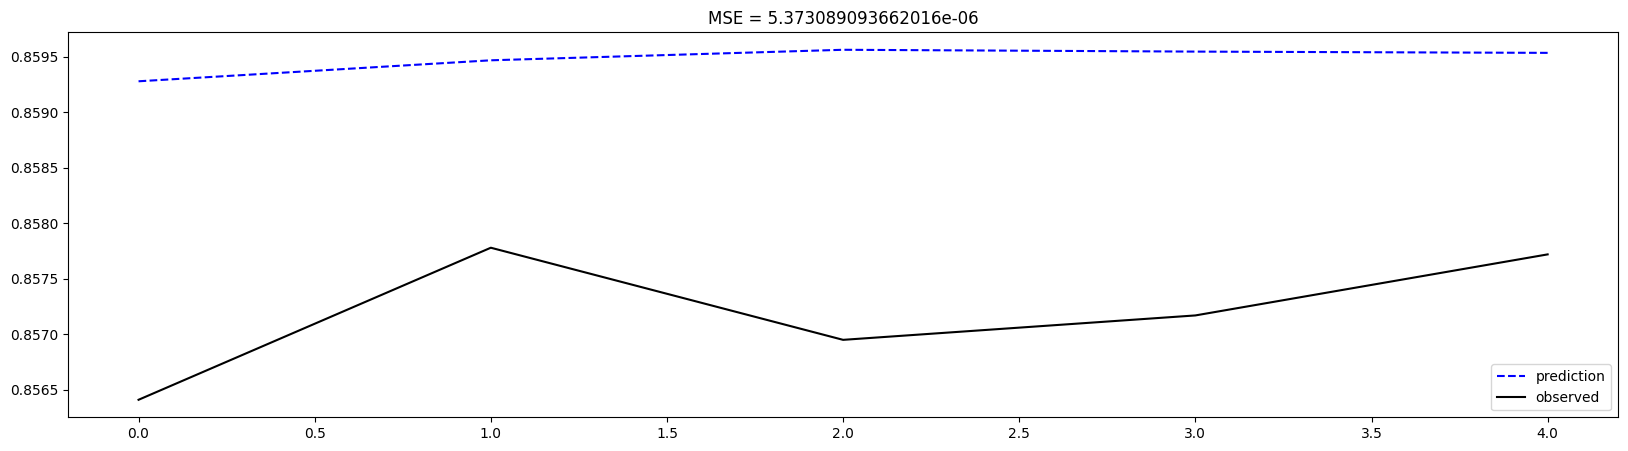

In [25]:
# plot prediction vs observed
pred = pd.DataFrame()
pred['prediction'] = data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['FTSE']]).reset_index(drop=True).Close)
pred['observed'] = test.reset_index(drop=True).Close

pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'])
plt.title(f"MSE = {np.mean((pred['prediction'].values-pred['observed'].values)**2)}")


In [26]:
# Train all the data using the best p and q parameters
diff_data_all = diff(df[['Close','Gold','Stoxx','FTSE', 'High', 'Low']], k_diff=1)
model = VARMAX(endog=diff_data_all[['Close', 'High', 'Low', 'Gold']], order=(1,4), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse', exog=diff_data_all[['FTSE']])
model_fit_final = model.fit(disp=False)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [27]:
model_fit_final.forecast(5, exog=diff_test[['FTSE']])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


,Close,High,Low,Gold
244,-0.000828,-0.000136,-0.000814,0.590927
245,-0.000954,-0.000489,-0.000337,1.514210
246,-0.000698,0.000167,-0.000282,-3.298847
247,0.000292,0.000381,0.000349,-2.070080
248,-0.000117,-0.000205,0.000147,0.338157


In [28]:
forecast_vals = eur_gbp.iloc[-1]['Close'] + np.cumsum(model_fit_final.forecast(5, exog=diff_test[['FTSE']]).reset_index(drop=True).Close)
print(forecast_vals)


0    0.856892
1    0.855938
2    0.855239
3    0.855531
4    0.855414
Name: Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [79]:
forecast_vals.values.tofile("./predictions_eurgbp.csv", sep=',')